# Anomaly detection – find unusual events
Fraud detection is a subset of anomaly detection, fraud has to be intentional


### Data Source
https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

city of NY think there might be some property tax fraud going on in their city, but they’re not sure. This project is to build an algorithmic system that can look through their ~1 million property records to find potential tax fraud.
The kind of fraud they’re looking for is people underpaying tax or otherwise misrepresenting their property characteristics.

Major components of the analysis include:
```
1. Data cleaning and filling in missing fields
2. Designing and building new variables
3. Dimensionality reduction through PCA process
4. Calculating and comparing fraud score using heuristic algorithm and autoencoder methods


File Name: Property_Valuation_and_Assessment_Data.xlsx
Data Provided by: Department of Finance (DOF)
Dataset Owner: NYC OpenData
Category: Housing & Development
Date Created: September 2, 2011
Last Updated: September 10, 2018
Data Volume: 1,070,994
Fields: 32 fields
Field Variables: RECORD, BBLE, B, BLOCK, LOT, EASEMENT, OWNER, BLDGCL, TAXCLASS, LTFRONT, LTDEPTH, EXT, STORIES, FULLVAL, AVLAND, AVTOT, EXLAND, EXTOT, EXCD1, STADDR, ZIP, EXMPTCL, BLDFRONT, BLDDEPTH, AVLAND2, AVTOT2, EXLAND2, EXTOT2, EXCD2, PERIOD, YEAR, and VALTYPE.
```
## Data Exploration

In [1]:
import pandas as pd
import numpy as np

In [2]:
mydata = pd.read_csv("NY_v2.csv")
mydata.head()

,Unnamed: 0,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new
0,0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,11,11101,10004
1,1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,11,11201,10004
2,2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,12,121,10004
3,3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,12,1223,10004
4,4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,13,131,10004


In [3]:
#drop the first column
mydata.drop(mydata.columns[0], axis=1, inplace=True)

In [4]:
mydata.count()

RECORD      1070994
BBLE        1070994
B           1070994
BLOCK       1070994
LOT         1070994
EASEMENT       4636
OWNER       1039249
BLDGCL      1070994
TAXCLASS    1070994
LTFRONT     1070994
LTDEPTH     1070994
EXT          354305
STORIES     1070994
FULLVAL     1070994
AVLAND      1070994
AVTOT       1070994
EXLAND      1070994
EXTOT       1070994
EXCD1        638488
STADDR      1070318
ZIP         1041104
EXMPTCL       15579
BLDFRONT    1070994
BLDDEPTH    1070994
AVLAND2      282726
AVTOT2       282732
EXLAND2       87449
EXTOT2       130828
EXCD2         92948
PERIOD      1070994
YEAR        1070994
VALTYPE     1070994
BB          1070994
BBL         1070994
ZIP_new     1070994
dtype: int64

In [5]:
# replace zeros with NaN 
values = ["FULLVAL", "AVLAND", "AVTOT", 'LTFRONT', 'LTDEPTH', 'BLDFRONT','BLDDEPTH']
mydata[values] = mydata[values].replace({0:np.nan})

In [6]:
mydata.count()

RECORD      1070994
BBLE        1070994
B           1070994
BLOCK       1070994
LOT         1070994
EASEMENT       4636
OWNER       1039249
BLDGCL      1070994
TAXCLASS    1070994
LTFRONT      901886
LTDEPTH      900866
EXT          354305
STORIES     1070994
FULLVAL     1057987
AVLAND      1057985
AVTOT       1057987
EXLAND      1070994
EXTOT       1070994
EXCD1        638488
STADDR      1070318
ZIP         1041104
EXMPTCL       15579
BLDFRONT     842179
BLDDEPTH     842141
AVLAND2      282726
AVTOT2       282732
EXLAND2       87449
EXTOT2       130828
EXCD2         92948
PERIOD      1070994
YEAR        1070994
VALTYPE     1070994
BB          1070994
BBL         1070994
ZIP_new     1070994
dtype: int64

## Step 1: Data cleaning
### Group by ZIP_new and TAXCLASS, exclude groups that have less than 5 records

In [7]:
# group by ZIP_new and TAXCLASS, and create a new column that saves the count of each group
# mydata.groupby(["ZIP_new", "TAXCLASS"]).count()
#mydata["group_count"] = mydata.groupby(["ZIP_new", "TAXCLASS"])["RECORD"].transform("count")

In [8]:
mydata.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,11,11101,10004
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,11,11201,10004
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,12,121,10004
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,12,1223,10004
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,13,131,10004


In [9]:
# only fill NaN if the group has bigger than 5 records
#group_gt_5 = mydata.group_count > 5
for value in values:
    mydata["group_count"] = mydata.groupby(["ZIP_new", "TAXCLASS"])[value].transform("count")
    group_gt_5 = mydata.group_count > 5
    mydata.loc[group_gt_5, value] = mydata.loc[group_gt_5, value].fillna(mydata.groupby(["ZIP_new", "TAXCLASS"])[value].transform("median"))

In [10]:
mydata.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new,group_count
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,...,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,11,11101,10004,133
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,...,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,11,11201,10004,133
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,...,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,12,121,10004,133
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,...,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,12,1223,10004,133
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,...,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,13,131,10004,133


In [11]:
mydata.count()

RECORD         1070994
BBLE           1070994
B              1070994
BLOCK          1070994
LOT            1070994
EASEMENT          4636
OWNER          1039249
BLDGCL         1070994
TAXCLASS       1070994
LTFRONT        1066345
LTDEPTH        1066291
EXT             354305
STORIES        1070994
FULLVAL        1066384
AVLAND         1066384
AVTOT          1066384
EXLAND         1070994
EXTOT          1070994
EXCD1           638488
STADDR         1070318
ZIP            1041104
EXMPTCL          15579
BLDFRONT       1037483
BLDDEPTH       1037431
AVLAND2         282726
AVTOT2          282732
EXLAND2          87449
EXTOT2          130828
EXCD2            92948
PERIOD         1070994
YEAR           1070994
VALTYPE        1070994
BB             1070994
BBL            1070994
ZIP_new        1070994
group_count    1070994
dtype: int64

### Group by B and TAXCLASS, exclude groups that have less than 5 records

In [12]:
# For the rest of the NaN, we group by zip code only
# group by ZIP_new only, and create a new column that saves the count of zip code group
#mydata["group_Btax_count"] = mydata.groupby(["B","TAXCLASS"])["RECORD"].transform("count")
mydata.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new,group_count
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,...,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,11,11101,10004,133
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,...,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,11,11201,10004,133
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,...,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,12,121,10004,133
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,...,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,12,1223,10004,133
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,...,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,13,131,10004,133


In [13]:
# only fill NaN if the zip group has bigger than 5 records
#group_gt_5 = mydata.group_Btax_count > 5
for value in values:
    mydata["group_Btax_count"] = mydata.groupby(["B","TAXCLASS"])[value].transform("count")
    group_gt_5 = mydata.group_Btax_count > 5
    mydata.loc[group_gt_5, value] = mydata.loc[group_gt_5, value].fillna(mydata.groupby(["B", "TAXCLASS"])[value].transform("median"))

In [14]:
mydata.count()

RECORD              1070994
BBLE                1070994
B                   1070994
BLOCK               1070994
LOT                 1070994
EASEMENT               4636
OWNER               1039249
BLDGCL              1070994
TAXCLASS            1070994
LTFRONT             1070893
LTDEPTH             1070893
EXT                  354305
STORIES             1070994
FULLVAL             1069029
AVLAND              1069029
AVTOT               1069029
EXLAND              1070994
EXTOT               1070994
EXCD1                638488
STADDR              1070318
ZIP                 1041104
EXMPTCL               15579
BLDFRONT            1041516
BLDDEPTH            1041518
AVLAND2              282726
AVTOT2               282732
EXLAND2               87449
EXTOT2               130828
EXCD2                 92948
PERIOD              1070994
YEAR                1070994
VALTYPE             1070994
BB                  1070994
BBL                 1070994
ZIP_new             1070994
group_count         

### Group by B only, and all the NaN are filled

In [15]:
# For the rest of the NaN, we group by tax class only
# group by tax class only, and create a new column to save the count of the tax class group
#mydata["group_B_count"] = mydata.groupby("B")["RECORD"].transform("count")
mydata.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new,group_count,group_Btax_count
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,...,8613000.0,NaN,FINAL,2010/11,AC-TR,11,11101,10004,133,21009
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,...,80690400.0,NaN,FINAL,2010/11,AC-TR,11,11201,10004,133,21009
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,...,40179510.0,NaN,FINAL,2010/11,AC-TR,12,121,10004,133,21009
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,...,15750000.0,NaN,FINAL,2010/11,AC-TR,12,1223,10004,133,21009
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,...,107758350.0,NaN,FINAL,2010/11,AC-TR,13,131,10004,133,21009


In [16]:
#group_gt_5 = mydata.group_B_count > 5
for value in values:
    mydata["group_B_count"] = mydata.groupby("B")[value].transform("count")
    group_gt_5 = mydata.group_B_count > 5
    mydata.loc[group_gt_5, value] = mydata.loc[group_gt_5, value].fillna(mydata.groupby(["B"])[value].transform("median"))

In [17]:
mydata.count()

RECORD              1070994
BBLE                1070994
B                   1070994
BLOCK               1070994
LOT                 1070994
EASEMENT               4636
OWNER               1039249
BLDGCL              1070994
TAXCLASS            1070994
LTFRONT             1070994
LTDEPTH             1070994
EXT                  354305
STORIES             1070994
FULLVAL             1070994
AVLAND              1070994
AVTOT               1070994
EXLAND              1070994
EXTOT               1070994
EXCD1                638488
STADDR              1070318
ZIP                 1041104
EXMPTCL               15579
BLDFRONT            1070994
BLDDEPTH            1070994
AVLAND2              282726
AVTOT2               282732
EXLAND2               87449
EXTOT2               130828
EXCD2                 92948
PERIOD              1070994
YEAR                1070994
VALTYPE             1070994
BB                  1070994
BBL                 1070994
ZIP_new             1070994
group_count         

In [18]:
column_we_need = ["RECORD", "ZIP_new", "STORIES", "TAXCLASS", "B", "FULLVAL", "AVLAND", "AVTOT", 'LTFRONT', 'LTDEPTH', 'BLDFRONT','BLDDEPTH']
final_data = mydata[column_we_need]
final_data.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,152.0,207.0
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,152.0,207.0
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,709.0,564.0
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,85.0,551.0
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,89.0,57.0


In [19]:
# There is no NaN value!!! YEAH!!!!!
final_data.isnull().sum()

RECORD      0
ZIP_new     0
STORIES     0
TAXCLASS    0
B           0
FULLVAL     0
AVLAND      0
AVTOT       0
LTFRONT     0
LTDEPTH     0
BLDFRONT    0
BLDDEPTH    0
dtype: int64

In [20]:
final_data.to_csv("NY_cleaned.csv", index=False)

## Step 2: Create 45 new variables

Create field ZIP3 &
Create these 3 variables:
 ```
lotarea = LTFRONT * LTDEPTH
bldarea = BLDFRONT * BLDDEPTH
bldvol = bldarea * STORIES
```

Calculate 9 variables, each of the 3 values normalized by each of these 3 sizes (3 * 3 = 9 variables)
Create the grouped averages of these 9 variables, grouped by 
 ```zip5, zip3, taxclass, borough, all```
Divide each of the 9 core variables by the 5 scale factors from these groupings
This makes 9 * 5 = 45 variables


In [21]:
import pandas as pd
import numpy as np

In [22]:
tb_12col=pd.read_csv("NY_cleaned.csv")
tb_12col.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,152.0,207.0
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,152.0,207.0
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,709.0,564.0
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,85.0,551.0
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,89.0,57.0


In [23]:
tb_12col['ZIP3'] = tb_12col['ZIP_new'].astype(str).str[:3].astype(int)

In [24]:
new_3field=['lotarea','bldarea','bldvol']

tb_12col['lotarea']=tb_12col['LTFRONT'] * tb_12col['LTDEPTH']
tb_12col['bldarea']=tb_12col['BLDFRONT'] * tb_12col['BLDDEPTH']
tb_12col['bldvol']=tb_12col['bldarea'] * tb_12col['STORIES']

In [25]:
tb_12col.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,ZIP3,lotarea,bldarea,bldvol
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,152.0,207.0,100,523000.0,31464.0,1573200.0
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,152.0,207.0,100,5589.0,31464.0,1573200.0
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,709.0,564.0,100,399876.0,399876.0,1199628.0
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,85.0,551.0,100,436943.0,46835.0,93670.0
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,89.0,57.0,100,406980.0,5073.0,5073.0


Calculate 9 variables, each of the 3 values normalized by each of the 3 sizes (3 * 3 = 9 variables)

In [26]:
V = ['FULLVAL','AVLAND','AVTOT']
S = ['lotarea','bldarea','bldvol']

tb_12col['r1']=tb_12col[V[0]]/tb_12col[S[0]]
tb_12col['r2']=tb_12col[V[0]]/tb_12col[S[1]]
tb_12col['r3']=tb_12col[V[0]]/tb_12col[S[2]]

tb_12col['r4']=tb_12col[V[1]]/tb_12col[S[0]]
tb_12col['r5']=tb_12col[V[1]]/tb_12col[S[1]]
tb_12col['r6']=tb_12col[V[1]]/tb_12col[S[2]]

tb_12col['r7']=tb_12col[V[2]]/tb_12col[S[0]]
tb_12col['r8']=tb_12col[V[2]]/tb_12col[S[1]]
tb_12col['r9']=tb_12col[V[2]]/tb_12col[S[2]]


In [27]:
tb_12col.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,...,1573200.0,40.917782,680.142385,13.602848,8.079350,134.296339,2.685927,18.413002,306.064073,6.121281
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,...,1573200.0,34675.254965,6159.420290,123.188406,2560.386473,454.805492,9.096110,15603.864734,2771.739130,55.434783
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,...,1199628.0,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,...,93670.0,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,...,5073.0,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541


Separately group records by these 5 groups: zip5, zip3, TAXCLASS, borough, all (no group)

In [28]:
r=['r1','r2','r3','r4','r5','r6','r7','r8','r9']

for i in r:
    tb_12col[i+'_zip5']=tb_12col.groupby('ZIP_new')[i].transform('mean')
    tb_12col[i+'_zip3']=tb_12col.groupby('ZIP3')[i].transform('mean')
    tb_12col[i+'_TAXCLASS']=tb_12col.groupby('TAXCLASS')[i].transform('mean')
    tb_12col[i+'_B']=tb_12col.groupby('B')[i].transform('mean')
tb_12col.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,...,r7_TAXCLASS,r7_B,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105


In [29]:
forty_five_fields=tb_12col.loc[:,'r1':]
forty_five_fields.shape

(1070994, 45)

In [30]:
forty_five_fields.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r7_TAXCLASS,r7_B,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,40.917782,680.142385,13.602848,8.079350,134.296339,2.685927,18.413002,306.064073,6.121281,338.47145,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
1,34675.254965,6159.420290,123.188406,2560.386473,454.805492,9.096110,15603.864734,2771.739130,55.434783,338.47145,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
2,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,338.47145,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
3,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,338.47145,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105
4,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,338.47145,...,105.89514,99.11054,181.993239,153.801137,327.468023,149.732618,57.819603,36.726622,145.65525,35.300105


In [35]:
new_forty_five=pd.DataFrame()
r=['r1','r2','r3','r4','r5','r6','r7','r8','r9']

for i in r:
    new_forty_five[i+'_all']=forty_five_fields[i]/forty_five_fields[i].mean()
    new_forty_five[i+'_zip5']=forty_five_fields[i]/forty_five_fields[i+'_zip5']
    new_forty_five[i+'_zip3']=forty_five_fields[i]/forty_five_fields[i+'_zip3']
    new_forty_five[i+'_TAXCLASS']=forty_five_fields[i]/forty_five_fields[i+'_TAXCLASS']
    new_forty_five[i+'_B']=forty_five_fields[i]/forty_five_fields[i+'_B']

new_forty_five.head()

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,0.192651,0.120890,0.107328,0.173949,0.109930,1.148437,1.564898,1.182297,0.988498,1.207497,...,4.519856,1.681733,1.989999,0.934638,2.044071,0.218135,0.105869,0.166672,0.042026,0.173407
1,163.259630,102.446617,90.953371,147.410526,93.158506,10.400332,14.171831,10.706966,8.951911,10.935184,...,40.932154,15.229902,18.021578,8.464152,18.511258,1.975450,0.958754,1.509390,0.380589,1.570386
2,1.232601,0.773466,0.686693,1.112941,0.703341,0.442049,0.602351,0.455082,0.380486,0.464782,...,1.739755,0.647322,0.765978,0.359755,0.786791,1.399389,0.679171,1.069236,0.269605,1.112445
3,0.422397,0.265057,0.235321,0.381391,0.241026,1.413263,1.925758,1.454930,1.216442,1.485942,...,5.562119,2.069535,2.448886,1.150162,2.515427,6.710917,3.257039,5.127635,1.292921,5.334848
4,3.150168,1.976754,1.754986,2.844352,1.797535,90.633792,123.500555,93.305956,78.011511,95.294762,...,356.703635,132.721120,157.049206,73.760932,161.316531,860.754053,417.753586,657.679496,165.832309,684.257067


## Step 3: Z scaled ->PCA -> Z scaled again

PCA is an unsupervised technique used to transform high dimensional data into a smaller dimensional subspace before fitting a machine-learning algorithm. It enables us to summarize the variations in the NY property dataset by lowering dimensions and projecting data onto a new orthogonal-rotated coordinate system.

1. Z scale 
2. PCA, keep top ~5 to 10 PCs; look at the eigenvalues and keep up to 90%
3. Represent each record in this new reduced space of the PCs
4. Z scale the data fields again 

The new coordinate system that PCA generates has the origin at the center of the data, so we were able to better visualize and detect potential frauds by calculating the distance between certain records and the origin. The transformed data that we obtained from PCA became crucial for our fraud algorithms, which are respectively Euclidean Distance and Autoencoder. By cutting down variables, we were also able to decrease the training time of algorithms and storage space needed.

In [39]:
new_forty_five.to_csv('beforeNormalized_45.csv',index=False)

In [42]:
data=pd.read_csv('beforeNormalized_45.csv')
data.head()

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,0.192651,0.120890,0.107328,0.173949,0.109930,1.148437,1.564898,1.182297,0.988498,1.207497,...,4.519856,1.681733,1.989999,0.934638,2.044071,0.218135,0.105869,0.166672,0.042026,0.173407
1,163.259630,102.446617,90.953371,147.410526,93.158506,10.400332,14.171831,10.706966,8.951911,10.935184,...,40.932154,15.229902,18.021578,8.464152,18.511258,1.975450,0.958754,1.509390,0.380589,1.570386
2,1.232601,0.773466,0.686693,1.112941,0.703341,0.442049,0.602351,0.455082,0.380486,0.464782,...,1.739755,0.647322,0.765978,0.359755,0.786791,1.399389,0.679171,1.069236,0.269605,1.112445
3,0.422397,0.265057,0.235321,0.381391,0.241026,1.413263,1.925758,1.454930,1.216442,1.485942,...,5.562119,2.069535,2.448886,1.150162,2.515427,6.710917,3.257039,5.127635,1.292921,5.334848
4,3.150168,1.976754,1.754986,2.844352,1.797535,90.633792,123.500555,93.305956,78.011511,95.294762,...,356.703635,132.721120,157.049206,73.760932,161.316531,860.754053,417.753586,657.679496,165.832309,684.257067


In [36]:
ls=list(new_forty_five.columns)
nor_new_45=pd.DataFrame()

for i in ls:
    nor_new_45[i]=(new_forty_five[i]-new_forty_five[i].mean())/new_forty_five[i].std()

nor_new_45.head()

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,-0.158695,-0.236201,-0.135153,-0.143767,-0.133590,0.010989,0.068317,0.015784,-0.000483,0.016332,...,0.066444,0.042397,0.021663,-0.002639,0.020130,-0.013356,-0.048033,-0.016757,-0.011541,-0.016390
1,31.894268,27.256834,13.619209,25.481489,13.831979,0.695904,1.592958,0.840474,0.333776,0.782003,...,0.753801,0.884952,0.372464,0.301400,0.337618,0.016663,-0.002216,0.010243,-0.007462,0.011310
2,0.045721,-0.060866,-0.047436,0.019656,-0.044525,-0.041305,-0.048090,-0.047181,-0.026004,-0.042127,...,0.013964,-0.021933,-0.005121,-0.025853,-0.004111,0.006823,-0.017235,0.001392,-0.008799,0.002230
3,-0.113536,-0.197466,-0.115775,-0.107664,-0.113914,0.030594,0.111958,0.039390,0.009085,0.038249,...,0.086119,0.066514,0.031704,0.006064,0.029217,0.097558,0.121249,0.083001,0.003529,0.085952
4,0.422644,0.262436,0.114307,0.320994,0.119701,6.635567,14.814811,7.992274,3.232508,7.421985,...,6.714629,8.191684,3.414653,2.938063,3.090910,14.687012,22.388087,13.204917,1.985730,13.547709


In [43]:
nor_new_45.to_csv('nor_new_45.csv',index=False)

In [ ]:
scaled_data=pd.read_csv('nor_new_45.csv')
scaled_data.head()

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca=PCA()
pca.fit(scaled_data)
scaled_data.shape

(1070994, 45)

In [47]:
np.arange(1,46)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

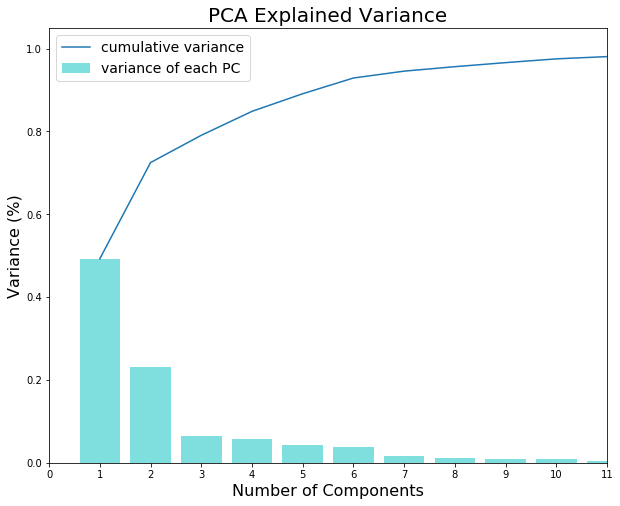

<Figure size 432x288 with 0 Axes>

In [81]:
plt.figure(figsize=[10,8])
len(pca.explained_variance_ratio_)
plt.plot(np.arange(1,46),np.cumsum(pca.explained_variance_ratio_),label='cumulative variance')
plt.bar(np.arange(1,46),pca.explained_variance_ratio_, alpha=0.5,color='c',label='variance of each PC')
plt.xlabel('Number of Components',size=16)
plt.xticks(range(0,12,1))
plt.ylabel('Variance (%)',size=16) #for each component
plt.xlim(0,11)
plt.title('PCA Explained Variance',size=20)
plt.legend(loc=0,prop={'size': 14})
plt.show()
plt.savefig('PCA.png')

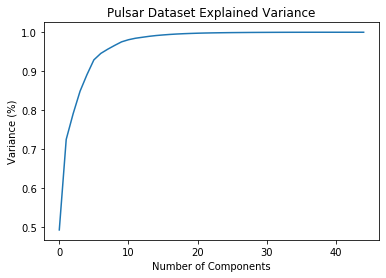

In [56]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [66]:
cum_var=0
for i,v in enumerate(pca.explained_variance_ratio_):
    cum_var+=v
    if cum_var>0.9:
        print(i+1) 
        break

6


In [74]:
pca=PCA(n_components=6)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)

In [134]:
pca.explained_variance_ratio_.cumsum()

array([0.49256749, 0.72487491, 0.79073122, 0.848544  , 0.89109664,
       0.92907937])

In [70]:
df_comp=pd.DataFrame(pca.components_,columns=scaled_data.columns)
df_comp

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,0.044381,0.042072,0.035474,0.039276,0.035154,0.157862,0.170707,0.165434,0.182149,0.158156,...,0.161524,0.182342,0.174039,0.186828,0.161344,0.197589,0.177697,0.199123,0.164905,0.200460
1,0.269132,0.263666,0.252509,0.253685,0.252421,-0.029898,-0.033629,-0.027568,-0.066349,-0.027699,...,-0.021363,-0.032408,-0.008362,-0.065696,-0.009496,-0.049106,-0.037332,-0.030090,-0.077062,-0.032264
2,0.149435,0.147275,0.183428,0.170668,0.188028,-0.201354,-0.104177,-0.172578,0.084966,-0.204601,...,-0.236934,-0.102526,-0.132090,0.051777,-0.251536,0.085522,-0.043803,0.046211,0.275978,0.057109
3,-0.179062,-0.166314,-0.203044,-0.207378,-0.209033,-0.289144,-0.221569,-0.269314,-0.091970,-0.290024,...,-0.112521,-0.029945,0.061387,-0.074874,-0.085029,0.107572,0.025801,0.133307,0.093459,0.128778
4,-0.012247,0.000567,-0.018240,-0.018241,-0.019989,-0.052381,0.172428,0.020698,-0.180195,-0.030769,...,-0.235811,0.116583,-0.183922,-0.202699,-0.262284,-0.007904,0.275055,0.005987,-0.159146,0.003487
5,0.078706,0.082068,0.118558,0.107324,0.124177,-0.211809,-0.168363,-0.225708,-0.182803,-0.211298,...,0.178218,0.214670,0.244327,-0.088345,0.167779,0.119138,0.238689,0.134867,-0.114906,0.111077


In [80]:
df_pca=pd.DataFrame(x_pca)
df_pca.shape

(1070994, 6)

In [206]:
ls=df_pca.columns
zscaled_pca=pd.DataFrame()

for i in ls:
    zscaled_pca[i]=(df_pca[i]-df_pca[i].mean())/df_pca[i].std()


zscaled_pca.head()


,0,1,2,3,4,5
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043
1,3.333051,21.300696,5.220411,-5.958544,-0.555356,-0.846033
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397
4,13.046612,-3.397510,-0.067988,-2.603167,28.684489,2.262344


## Step 4: Score 1- heuristic algorithm: 

Simply measure the distance between the data point and the origin.

### Manhattan: 
sum of absolute zscores
### Euclediandistance): 
zscores squared

In [142]:
heuristic=zscaled_pca.copy()
ls=heuristic.columns
heuristic['heu_Manhattan']=0
heuristic['heu_Eucledian']=0

for i in ls:
    heuristic['heu_Manhattan']+= abs(heuristic[i])
    heuristic['heu_Eucledian']+= (abs(heuristic[i]))**2
heuristic['heu_Eucledian']=heuristic['heu_Eucledian']**(1/2)
heuristic.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,heu_Manhattan,heu_Eucledian
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.393136,0.189621
1,3.333051,21.300696,5.220411,-5.958544,-0.555356,-0.846033,37.214090,22.991521
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.442145,0.219174
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.491031,0.221683
4,13.046612,-3.397510,-0.067988,-2.603167,28.684489,2.262344,50.062110,31.881913


In [166]:
heuristic['Rank_heu_M']=heuristic['heu_Manhattan'].rank(ascending=False)
heuristic['Rank_heu_E']=heuristic['heu_Eucledian'].rank(ascending=False)
heuristic.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,heu_Manhattan,heu_Eucledian,Rank_heu_M,Rank_heu_E
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.393136,0.189621,296591.0,309105.0
1,3.333051,21.300696,5.220411,-5.958544,-0.555356,-0.846033,37.214090,22.991521,323.0,283.0
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.442145,0.219174,181508.0,128916.0
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.491031,0.221683,92350.0,125575.0
4,13.046612,-3.397510,-0.067988,-2.603167,28.684489,2.262344,50.062110,31.881913,247.0,203.0


In [187]:
#just checking
heuristic['Rank_heu_M'].sort_values().head()

632815     1.0
565391     2.0
1067359    3.0
917941     4.0
585117     5.0
Name: Rank_heu_M, dtype: float64

## Step 5: Score 2- Autoencoder:

Autoencoder on the z scaled PCs, and the fraud score is the reconstruction error

```
we employed a traditional artificial neural network, autoencoder, to compile alternative fraud scores and label anomaly records more precisely. We believe that the autoencoder is a relevant algorithm because it helps identify unusual properties by generalizing the initial data and seeking observations that stand out and do not follow universal patterns. Such generalization can be performed by compressing the original records and then recreating them from less available information. Since the learning pattern is primarily shaped by common, abundantly present observations, outlier records would therefore not be expected to be reproduced as well as others.
```

In [244]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [245]:
from keras.layers import Input,Dense
from keras.models import Model

In [246]:
zscaled_pca.head()

,0,1,2,3,4,5
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043
1,3.333051,21.300696,5.220411,-5.958544,-0.555356,-0.846033
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397
4,13.046612,-3.397510,-0.067988,-2.603167,28.684489,2.262344


In [247]:
#reference: 
# https://stackoverflow.com/questions/43739224/using-autoencoder-on-numerical-dataset-in-keras

input_size = zscaled_pca.shape[1]
hidden_size = 4 # number of neurons in the layer
code_size = 2 # number of neurons in the layer

input_layer = Input(shape=(input_size,)) # 7 is the number of features/columns
hidden_1 = Dense(hidden_size, activation='relu')(input_layer)
code = Dense(code_size,activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_layer = Dense(input_size, activation='tanh')(hidden_2)

# this model maps an input to its reconstruction
autoencoder = Model(input_layer, output_layer) 

# loss function and optimizer
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [189]:
autoencoder.fit(zscaled_pca.values, zscaled_pca.values,
                    epochs=50,
                    shuffle=True)

Epoch 1/50
1070994/1070994 [==============================] - 55s 51us/step - loss: 0.9783 - accuracy: 0.5937
Epoch 2/50
1070994/1070994 [==============================] - 43s 40us/step - loss: 0.9781 - accuracy: 0.5974
Epoch 3/50
1070994/1070994 [==============================] - 42s 39us/step - loss: 0.9779 - accuracy: 0.5993
Epoch 4/50
1070994/1070994 [==============================] - 42s 39us/step - loss: 0.9779 - accuracy: 0.5997
Epoch 5/50
1070994/1070994 [==============================] - 41s 39us/step - loss: 0.9778 - accuracy: 0.5964
Epoch 6/50
1070994/1070994 [==============================] - 42s 39us/step - loss: 0.9779 - accuracy: 0.5992
Epoch 7/50
1070994/1070994 [==============================] - 43s 40us/step - loss: 0.9779 - accuracy: 0.5997
Epoch 8/50
1070994/1070994 [==============================] - 141s 132us/step - loss: 0.9776 - accuracy: 0.6025
Epoch 9/50
1070994/1070994 [==============================] - 44s 41us/step - loss: 0.9775 - accuracy: 0.6034
Epoch 10

In [248]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 30        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [249]:
encoded_data = autoencoder.predict(zscaled_pca)
encoded_df=pd.DataFrame(encoded_data)
encoded_df.head()

,0,1,2,3,4,5
0,-0.006083,-0.004310,-0.001040,-0.001263,-0.003981,-0.004113
1,-0.999818,-0.997255,-0.661484,-0.746773,-0.995467,-0.996292
2,-0.012327,-0.008733,-0.002108,-0.002559,-0.008067,-0.008334
3,0.012329,-0.002103,0.006026,-0.013424,0.005410,-0.034131
4,-0.979952,-0.982894,-0.139338,-0.933837,-0.930338,-0.999841


In [250]:
zscaled_pca.head()

,0,1,2,3,4,5
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043
1,3.333051,21.300696,5.220411,-5.958544,-0.555356,-0.846033
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397
4,13.046612,-3.397510,-0.067988,-2.603167,28.684489,2.262344


In [251]:
ls=encoded_df.columns
encoded_df['auto_Manhattan']=0
encoded_df['auto_Eucledian']=0

for i in ls:
    encoded_df['auto_Manhattan']+= abs(encoded_df[i]-zscaled_pca[i])
    encoded_df['auto_Eucledian']+= (abs(encoded_df[i]-zscaled_pca[i]))**2
encoded_df['auto_Eucledian']=encoded_df['auto_Eucledian']**(1/2)
encoded_df.head()

,0,1,2,3,4,5,auto_Manhattan,auto_Eucledian
0,-0.006083,-0.004310,-0.001040,-0.001263,-0.003981,-0.004113,0.374872,0.184222
1,-0.999818,-0.997255,-0.661484,-0.746773,-0.995467,-0.996292,38.314857,24.040547
2,-0.012327,-0.008733,-0.002108,-0.002559,-0.008067,-0.008334,0.447255,0.221149
3,0.012329,-0.002103,0.006026,-0.013424,0.005410,-0.034131,0.499975,0.222238
4,-0.979952,-0.982894,-0.139338,-0.933837,-0.930338,-0.999841,51.058872,33.061253


In [252]:
encoded_df['Rank_auto_M']=encoded_df['auto_Manhattan'].rank(ascending=False)
encoded_df['Rank_auto_E']=encoded_df['auto_Eucledian'].rank(ascending=False)
encoded_df.head()

,0,1,2,3,4,5,auto_Manhattan,auto_Eucledian,Rank_auto_M,Rank_auto_E
0,-0.006083,-0.004310,-0.001040,-0.001263,-0.003981,-0.004113,0.374872,0.184222,320401.0,321041.0
1,-0.999818,-0.997255,-0.661484,-0.746773,-0.995467,-0.996292,38.314857,24.040547,327.0,281.0
2,-0.012327,-0.008733,-0.002108,-0.002559,-0.008067,-0.008334,0.447255,0.221149,115415.0,129793.0
3,0.012329,-0.002103,0.006026,-0.013424,0.005410,-0.034131,0.499975,0.222238,99346.0,128666.0
4,-0.979952,-0.982894,-0.139338,-0.933837,-0.930338,-0.999841,51.058872,33.061253,248.0,195.0


In [253]:
#just checking
encoded_df['Rank_auto_E'].sort_values().head()

632815     1.0
565391     2.0
1067359    3.0
917941     4.0
585117     5.0
Name: Rank_auto_E, dtype: float64

## Step 6: Combine scores:

Final fraud score is a combination of these two scaled scores

Use quantile binning/rank ordering to scale each score

In [254]:
combine=heuristic[['heu_Manhattan','heu_Eucledian','Rank_heu_M','Rank_heu_E']].join(encoded_df[['auto_Manhattan','auto_Eucledian','Rank_auto_M','Rank_auto_E']])
combine.head()

,heu_Manhattan,heu_Eucledian,Rank_heu_M,Rank_heu_E,auto_Manhattan,auto_Eucledian,Rank_auto_M,Rank_auto_E
0,0.393136,0.189621,296591.0,309105.0,0.374872,0.184222,320401.0,321041.0
1,37.214090,22.991521,323.0,283.0,38.314857,24.040547,327.0,281.0
2,0.442145,0.219174,181508.0,128916.0,0.447255,0.221149,115415.0,129793.0
3,0.491031,0.221683,92350.0,125575.0,0.499975,0.222238,99346.0,128666.0
4,50.062110,31.881913,247.0,203.0,51.058872,33.061253,248.0,195.0


In [255]:
combine['Rank_combine_M']=(combine['Rank_heu_M']+combine['Rank_auto_M'])/2
combine['Rank_combine_E']=(combine['Rank_heu_E']+combine['Rank_auto_E'])/2
combine.head()

,heu_Manhattan,heu_Eucledian,Rank_heu_M,Rank_heu_E,auto_Manhattan,auto_Eucledian,Rank_auto_M,Rank_auto_E,Rank_combine_M,Rank_combine_E
0,0.393136,0.189621,296591.0,309105.0,0.374872,0.184222,320401.0,321041.0,308496.0,315073.0
1,37.214090,22.991521,323.0,283.0,38.314857,24.040547,327.0,281.0,325.0,282.0
2,0.442145,0.219174,181508.0,128916.0,0.447255,0.221149,115415.0,129793.0,148461.5,129354.5
3,0.491031,0.221683,92350.0,125575.0,0.499975,0.222238,99346.0,128666.0,95848.0,127120.5
4,50.062110,31.881913,247.0,203.0,51.058872,33.061253,248.0,195.0,247.5,199.0


In [256]:
tb_12col=pd.read_csv("NY_cleaned.csv")
tb_12col.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,152.0,207.0
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,152.0,207.0
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,709.0,564.0
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,85.0,551.0
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,89.0,57.0


In [257]:
final=tb_12col.join(combine[['Rank_combine_M','Rank_combine_E']])
final.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,Rank_combine_M,Rank_combine_E
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,152.0,207.0,308496.0,315073.0
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,152.0,207.0,325.0,282.0
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,709.0,564.0,148461.5,129354.5
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,85.0,551.0,95848.0,127120.5
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,89.0,57.0,247.5,199.0


In [258]:
final.sort_values('Rank_combine_M').head(10)

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,Rank_combine_M,Rank_combine_E
632815,632816,11373,1.0,2,4,2.930000e+06,1.318500e+06,1.318500e+06,157.0,95.0,1.0,1.0,1.0,1.0
565391,565392,11225,2.0,4,3,4.326304e+09,1.946837e+09,1.946837e+09,117.0,108.0,42.0,85.0,2.0,2.0
1067359,1067360,10307,2.0,1,5,8.360000e+05,2.880000e+04,5.016000e+04,1.0,1.0,36.0,45.0,3.0,3.0
917941,917942,11422,3.0,4,4,3.740199e+08,1.792809e+09,4.668309e+09,4910.0,100.0,40.0,60.0,4.0,4.0
585117,585118,11101,20.0,4,4,3.443400e+06,1.549530e+06,1.549530e+06,298.0,402.0,1.0,1.0,5.0,5.0
585438,585439,11101,10.0,4,4,3.712000e+06,2.520000e+05,1.670400e+06,94.0,165.0,1.0,1.0,6.0,7.0
85885,85886,10023,1.0,4,1,7.021400e+07,3.145500e+07,3.159630e+07,4000.0,150.0,8.0,8.0,7.0,6.0
750815,750816,11367,2.0,1B,4,2.564350e+05,6.501000e+03,6.501000e+03,1.0,1.0,21.0,40.0,8.0,8.0
920627,920628,11691,2.0,1,4,1.900000e+06,9.763000e+03,7.576300e+04,91.0,100.0,1.0,1.0,9.0,10.0
585119,585120,11101,20.0,4,4,2.151600e+06,9.682200e+05,9.682200e+05,139.0,342.0,1.0,1.0,10.0,9.0


In [272]:
final.sort_values('Rank_combine_E').head(10)

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,Rank_combine_M,Rank_combine_E
632815,632816,11373,1.0,2,4,2.930000e+06,1.318500e+06,1.318500e+06,157.0,95.0,1.0,1.0,1.0,1.0
565391,565392,11225,2.0,4,3,4.326304e+09,1.946837e+09,1.946837e+09,117.0,108.0,42.0,85.0,2.0,2.0
1067359,1067360,10307,2.0,1,5,8.360000e+05,2.880000e+04,5.016000e+04,1.0,1.0,36.0,45.0,3.0,3.0
917941,917942,11422,3.0,4,4,3.740199e+08,1.792809e+09,4.668309e+09,4910.0,100.0,40.0,60.0,4.0,4.0
585117,585118,11101,20.0,4,4,3.443400e+06,1.549530e+06,1.549530e+06,298.0,402.0,1.0,1.0,5.0,5.0
85885,85886,10023,1.0,4,1,7.021400e+07,3.145500e+07,3.159630e+07,4000.0,150.0,8.0,8.0,7.0,6.0
585438,585439,11101,10.0,4,4,3.712000e+06,2.520000e+05,1.670400e+06,94.0,165.0,1.0,1.0,6.0,7.0
750815,750816,11367,2.0,1B,4,2.564350e+05,6.501000e+03,6.501000e+03,1.0,1.0,21.0,40.0,8.0,8.0
585119,585120,11101,20.0,4,4,2.151600e+06,9.682200e+05,9.682200e+05,139.0,342.0,1.0,1.0,10.0,9.0
920627,920628,11691,2.0,1,4,1.900000e+06,9.763000e+03,7.576300e+04,91.0,100.0,1.0,1.0,9.0,10.0


## Step7: Examine the top 20 zip code


In [308]:
data=pd.read_csv('nor_new_45.csv')
data.head()

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,-0.158695,-0.236201,-0.135153,-0.143767,-0.133590,0.010989,0.068317,0.015784,-0.000483,0.016332,...,0.066444,0.042397,0.021663,-0.002639,0.020130,-0.013356,-0.048033,-0.016757,-0.011541,-0.016390
1,31.894268,27.256834,13.619209,25.481489,13.831979,0.695904,1.592958,0.840474,0.333776,0.782003,...,0.753801,0.884952,0.372464,0.301400,0.337618,0.016663,-0.002216,0.010243,-0.007462,0.011310
2,0.045721,-0.060866,-0.047436,0.019656,-0.044525,-0.041305,-0.048090,-0.047181,-0.026004,-0.042127,...,0.013964,-0.021933,-0.005121,-0.025853,-0.004111,0.006823,-0.017235,0.001392,-0.008799,0.002230
3,-0.113536,-0.197466,-0.115775,-0.107664,-0.113914,0.030594,0.111958,0.039390,0.009085,0.038249,...,0.086119,0.066514,0.031704,0.006064,0.029217,0.097558,0.121249,0.083001,0.003529,0.085952
4,0.422644,0.262436,0.114307,0.320994,0.119701,6.635567,14.814811,7.992274,3.232508,7.421985,...,6.714629,8.191684,3.414653,2.938063,3.090910,14.687012,22.388087,13.204917,1.985730,13.547709


In [309]:
examine=final[['RECORD','Rank_combine_E']].join(data)
examine.sort_values('Rank_combine_E').head(20)

,RECORD,Rank_combine_E,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,...,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
632815,632816,1.0,-0.014758,-0.016522,0.001747,0.239606,0.023383,366.179018,432.315435,393.182426,...,367.539314,476.077433,498.231887,815.667438,362.089116,802.627255,473.230582,751.250583,1026.179688,773.623328
565391,565392,2.0,316.664366,281.706397,212.589110,253.145519,210.810558,151.408453,143.253417,172.613684,...,152.003413,136.673487,267.751279,67.203896,236.884561,165.970009,117.792395,261.416818,22.539846,259.786392
1067359,1067360,3.0,773.494505,664.507964,916.628916,632.043258,910.585011,-0.009523,-0.084592,-0.007208,...,-0.010245,-0.041150,-0.007316,0.000188,-0.006414,-0.007658,-0.034499,-0.008161,0.000277,-0.007999
917941,917942,4.0,0.508413,1.645934,0.681733,0.389563,0.522575,19.406335,33.043081,21.523593,...,542.224578,382.657555,709.015555,239.811079,534.184318,394.685625,302.103559,421.905002,53.614372,380.421463
585117,585118,5.0,-0.169962,-0.202251,-0.131455,-0.152774,-0.124707,430.354552,213.194951,336.170573,...,431.943537,117.563149,156.297102,191.030281,425.538416,47.147175,48.269192,40.806874,6.395941,45.440289
85885,85886,6.0,-0.088262,-0.121243,-0.104929,-0.087458,-0.102902,137.063830,305.469360,165.037716,...,137.607674,225.783886,70.217660,60.836204,63.550079,300.520831,339.128431,270.287007,40.820640,277.287906
585438,585439,7.0,0.024929,0.284441,0.014691,0.003034,0.061251,463.929831,229.834507,362.400077,...,465.638462,126.738431,168.490654,205.934614,458.733746,101.669463,104.130893,88.003217,13.803631,97.992574
750815,750816,8.0,237.125768,301.410828,199.766315,446.160825,226.294525,-0.035869,-0.058535,-0.045609,...,-0.016720,-0.051438,-0.018957,-0.020955,-0.017155,-0.014727,-0.044974,-0.017904,-0.006234,-0.017558
585119,585120,9.0,-0.154676,-0.164078,-0.119992,-0.140554,-0.110122,268.878208,133.168970,210.022871,...,269.891772,73.435713,97.653650,119.349652,265.889397,29.453387,30.140732,25.490531,3.991969,28.385814
920627,920628,10.0,-0.003334,0.246665,0.120038,-0.016145,0.034284,237.427946,316.237235,232.425340,...,21.101571,105.869595,25.173707,99.225494,20.788015,23.043495,84.218418,20.231321,30.142733,22.207524
